# Solving a 2nd-order ODE IVP with a neural network

## Setup

In [38]:
%%javascript
MathJax.Hub.Config({
      TeX: { equationNumbers: { autoNumber: "AMS" } }
    });MathJax.Hub.Queue(
  ["resetEquationNumbers", MathJax.InputJax.TeX],
  ["PreProcess", MathJax.Hub],
  ["Reprocess", MathJax.Hub]
);
MathJax.Hub.Queue(
  ["resetEquationNumbers", MathJax.InputJax.TeX],
  ["PreProcess", MathJax.Hub],
  ["Reprocess", MathJax.Hub]
);

<IPython.core.display.Javascript object>

In [39]:
from math import exp, cos, sin
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# Introduction

This notebook will demonstrate how to use the code in the `nnode2ivp.py` module. The module allows the user to solve 2nd-order ordinary differential equation (ODE) initial value problems (IVPs) using a single-hidden layer neural network.

This work is based on the paper "Artificial Neural Networks for Solving Ordinary and Partial Differential Equations", by Lagaris et al, *IEEE Transactions on Neural Networks, Volume 9, No. 5*, September 1998. Note that the notation used in this notebook and the associated Python code is slightly different from that used in the Lagaris paper.

## The algorithm

Any 2nd-order ODE can be written in the form:

\begin{equation}
G\left(x,y,\frac {dy}{dx},\frac {d^2y}{dx^2}\right) = 0
\end{equation}

The problem is to find a solution $y(x)$ to the ODE using a neural network, subject to the initial conditions:

\begin{equation}
y(0) = A
\end{equation}

\begin{equation}
\frac {dy}{dx}(0) = A'
\end{equation}

The network is trained using a set of *training points*, defined on the domain of interest. The training points need not be evenly-spaced. Note that only the independent variable values $x_i$ of the training points are needed - the estimated value of the solution at those training points is obtained using a trial solution. For 2nd-order ODE IVP, the trial solution has the form:

\begin{equation}
y_t(x_i) = A(x_i) + P_1(x_i) A'(x_i) + P_2(x_i) N(x_i)
\end{equation}

The coefficient functions for this case are:

\begin{equation}
A(x_i) = A
\end{equation}

\begin{equation}
P_1(x_i) = x_i
\end{equation}

\begin{equation}
A'(x_i) = A'
\end{equation}

\begin{equation}
P_2(x_i) = x_i^2
\end{equation}

The trial solution can be written more compactly as:

\begin{equation}
y_{ti} = A + x_i A' + x_i^2 N_i
\end{equation}

where $y_{ti}=y_t(x_i,\vec p)$ is the value of the trial solution at the current training point $x_i$, and $N_i=N(x_i,\vec p)$ is the single-valued floating-point output from an unspecified neural network with parameters $\vec p$. Note that this trial solution satisfies the initial conditions by construction - at $x=0$, the second and third terms vanish, leaving $y_t(0)=A$. The derivative of $y_{ti}$ becomes $A'$ at $x=0$ in a similar fashion.

Training is done in a set of *epochs*. A training epoch consists of presenting the neural network with each of the $n$ training points $x_i$, one at a time. For each input value $x_i$, the network output $N_i$ is computed, and used to compute the value of the trial solution $y_{ti}$. Once all $n$ points have been presented, the epoch is complete, and the error function $E$ is computed. The ODE definition (1) should vanish at convergence, and so an appropriate form for the error function is:

\begin{equation}
E = \sum_{j=1}^{n}G_i^2
\end{equation}

where $G_i$ is:

\begin{equation}
G_i = G\left(x_i,y_{ti},\frac {\partial y_{ti}}{\partial x_i},\frac {\partial^2 y_{ti}}{\partial x_i^2}\right)
\end{equation}

## Computing the network output $N_i$

The neural network used in this work has a simple structure. A single input node is used to provide the training data. The input node is fully-connected to a set of $H$ hidden nodes. Each hidden node is connected to a single output node.

During each step of a training epoch, the input to the network, and thus the output of the single input node, is just the training point $x_i$. This single output is then sent to each of the $H$ hidden nodes. At each hidden node $k$, the input value $x_i$ is transformed by the equation:

\begin{equation}
z_{ik} = w_k x_i + u_k
\end{equation}

where $z_{ik}$ is the transformed input at hidden node $k$, $w_k$ is the weight at node $k$, and $u_k$ is the bias at node $k$. This transformed value is then used as the input to a sigmoidal transfer function:

\begin{equation}
\sigma_{ik} = \sigma(z_{ik})
\end{equation}

where:

\begin{equation}
\sigma(z) = \frac {1}{1+e^{-z}}
\end{equation}

A plot of this transfer function and its first several derivatives is provided below.

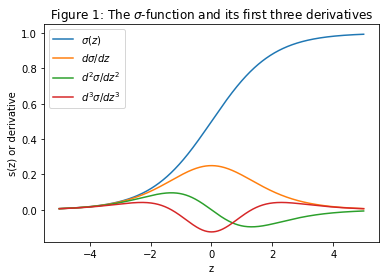

In [40]:
def sigma(z):
    return 1 / (1 + exp(-z))

def dsigma_dz(z):
    return exp(-z) / (1 + exp(-z))**2

def d2sigma_dz2(z):
    return (
        2 * exp(-2 * z) / (1 + exp(-z))**3 - exp(-z) / (1 + exp(-z))**2
    )

def d3sigma_dz3(z):
    return (
        6 * exp(-3 * z) / (1 + exp(-z))**4
        - 6 * exp(-2 * z) / (1 + exp(-z))**3
        + exp(-z) / (1 + exp(-z))**2
    )

z = np.linspace(-5, 5, 1001)
n = len(z)
s = np.zeros(n)
ds_dz = np.zeros(n)
d2s_dz2 = np.zeros(n)
d3s_dz3 = np.zeros(n)
for i in range(n):
    s[i] = sigma(z[i])
    ds_dz[i] = dsigma_dz(z[i])
    d2s_dz2[i] = d2sigma_dz2(z[i])
    d3s_dz3[i] = d3sigma_dz3(z[i])
plt.plot(z,s,label = "$\sigma(z)$")
plt.plot(z,ds_dz,label = "$d\sigma/dz$")
plt.plot(z,d2s_dz2, label = "$d^2\sigma/dz^2$")
plt.plot(z,d3s_dz3, label = "$d^3\sigma/dz^3$");
plt.xlabel("z")
plt.ylabel("s(z) or derivative")
plt.title("Figure 1: The $\sigma$-function and its first three derivatives")
plt.legend();

Once the $\sigma_{ij}$ are computed, they are all passed to the single output node, where they are summed by a linear transfer function to create the network output for the current value of $x_i$:

\begin{equation}
N_i = \sum_{k=1}^{H} v_k \sigma_{ik}
\end{equation}

where $v_k$ is the weight applied to signal from hidden node $k$ at the output node. Once $N_i$ has been computed, the trial function $y_{ti}$ and its derivatives $\frac {\partial y_{ti}}{\partial x_i}$ and $\frac {\partial^2 y_{ti}}{\partial x_i^2}$ are computed, and then the value of the ODE $G_i$ is computed, and finally the error function $E$.

## Updating the network parameters

The network parameters are the weights and biases of the hidden and output nodes. For a set of $H$ hidden nodes, we have a total of $N_p = 3H$ parameters in total: a weight and bias for each hidden node, and an output weight for each hidden node.

Since the objective function to minimize is the error $E$, the value of each network parameter $p$ (where $p$ represents $v_k$, $u_k$, or $w_k$) is updated using a scaled, simplified Newton's method:

\begin{equation}
p_{new} = p - \eta \frac {\partial E}{\partial p_j}
\end{equation}

where $\eta$ is the *learning rate* (usually $\eta < 1$). This simplified method (ignoring the usual 2nd derivative in the denominator of the correction term) is appropriate when the problem is scaled to the domain $[0,1]$.The learning rate is used to reduce the chance of solution instability due to large values of the correction term. The derivatives of $E$ are computed using the known form of the network and internal parameters.

This process of parameter updates is repeated until convergence is achieved (an error minimum is reached), or until the specified maximum number of training epochs have been applied. Note that the same set of training points is presented during each epoch.

## Computing the derivatives of $E$

The partial derivative of $E$ with respect to any network parameter $p$ is given by:

\begin{equation}
\frac {\partial E}{\partial p} =
\frac {\partial}{\partial p} \sum_{i=1}^{n}G_i^2 =
2 \sum_{i=1}^n G_i \frac {\partial G_i}{\partial p}
\end{equation}

## Computing the derivatives of $G_i$

The partial derivative of $G_i$ with respect to any network parameter $p$ is computed using the chain rule:

\begin{equation}
\frac {\partial G_i}{\partial p} =
\frac {\partial}{\partial p} G\left(x_i,y_{ti},\frac {\partial y_{ti}}{\partial x_i},\frac {\partial^2y_{ti}}{\partial x_i^2}\right) =
\sum_{i=1}^n \left ( \frac {\partial G_i}{\partial x_i} \frac {\partial x_i}{\partial p} \right ) +
\frac {\partial G_i}{\partial y_{ti}} \frac {\partial y_{ti}}{\partial x_i} +
\sum_{i=1}^n \frac {\partial G_i}{\partial \frac {\partial y_{ti}}{\partial x_i}} \frac {\partial^2 y_{ti}}{\partial p \partial x_i} +
\sum_{i=1}^n \frac {\partial G_i}{\partial \frac {\partial^2 y_{ti}}{\partial x_i^2}} \frac {\partial^3 y_{ti}}{\partial p \partial x_i^2}
\end{equation}

Since the training points $x_i$ are independent of the network parameters $\vec p$, this equation simplifies to:

\begin{equation}
\frac {\partial G_i}{\partial p} =
\frac {\partial G_i}{\partial y_{ti}} \frac {\partial y_{ti}}{\partial x_i} +
\sum_{i=1}^n \frac {\partial G_i}{\partial \frac {\partial y_{ti}}{\partial x_i}} \frac {\partial^2 y_{ti}}{\partial p \partial x_i} +
\sum_{i=1}^n \frac {\partial G_i}{\partial \frac {\partial^2 y_{ti}}{\partial x_i^2}} \frac {\partial^3 y_{ti}}{\partial p \partial x_i^2}
\end{equation}

The analytical forms of $\frac {\partial G_i}{\partial y_{ti}}$, $\frac {\partial G_i}{\partial \frac {\partial y_{ti}}{\partial x_i}}$, and $\frac {\partial G_i}{\partial \frac {\partial^2 y_{ti}}{\partial x_i^2}}$ are determined from the analytical form of the original ODE.

## Computing the derivatives of $y_{ti}$

The generic form of the first derivative of $y_{ti}$ is:

\begin{equation}
\frac {\partial y_{ti}}{\partial x_i} = A' + x_i^2 \frac {\partial N_i}{\partial x_i} + 2 x_i N_i
\end{equation}

The cross-partial of $y_{ti}$ is then:

\begin{equation}
\frac {\partial^2 y_{ti}}{\partial p \partial x_i} =
x_i^2 \frac {\partial^2 N_i}{\partial p \partial x_i} +
2 x_i \frac {\partial N_i}{\partial p}
\end{equation}

The generic form of the second derivative of $y_{ti}$ is:

\begin{equation}
\frac {\partial^2 y_{ti}}{\partial x_i^2} =
x_i^2 \frac {\partial^2 N_i}{\partial x_i^2} +
2 x_i \frac {\partial N_i}{\partial x_i} +
2 x_i \frac {\partial N_i}{\partial x_i} +
2 N_i =
x_i^2 \frac {\partial^2 N_i}{\partial x_i^2} +
4 x_i \frac {\partial N_i}{\partial x_i} +
2 N_i
\end{equation}

The cross-partial is then:

\begin{equation}
\frac {\partial^3 y_{ti}}{\partial p \partial x_i^2} =
x_i^2 \frac {\partial^3 N_i}{\partial p \partial x_i^2} +
4 x_i \frac {\partial^2 N_i}{\partial p \partial x_i} +
2 \frac {\partial N_i}{\partial p}
\end{equation}

## Computing the derivatives of $N_i$

The generic form of the first derivative of $N_i$ with respect to $x_i$ is:

\begin{equation}
\frac {\partial N_i}{\partial x_i} =
\frac {\partial}{\partial x_i} \sum_{k=1}^H v_k \sigma_{ik} =
\sum_{k=1}^H v_k \frac {\partial \sigma_{ik}}{\partial x_i} =
\sum_{k=1}^H v_k \frac {\partial \sigma_{ik}}{\partial z_{ik}} \frac {\partial z_{ik}}{\partial x_i} =
\sum_{k=1}^H v_k \sigma_{ik}^{(1)} \frac {\partial z_{ik}}{\partial x_i} =
\sum_{k=1}^H v_k \sigma_{ik}^{(1)} w_k
\end{equation}

where the transfer function derivatives are defined by:

\begin{equation}
\sigma^{(n)} = \frac {\partial^n \sigma}{\partial z^n}
\end{equation}

For the parameter derivatives:

\begin{equation}
\frac {\partial N_i}{\partial p} =
\frac {\partial}{\partial p} \sum_{k=1}^H v_k \sigma_{ik} =
\sum_{k=1}^H \left ( v_k \frac {\partial \sigma_{ik}}{\partial p} + \frac {\partial v_k}{\partial p} \sigma_{ik}  \right ) =
\sum_{k=1}^H \left ( v_k \sigma_{ik}^{(1)} \frac {\partial z_{ik}}{\partial p} + \frac {\partial v_k}{\partial p} \sigma_{ik}  \right )
\end{equation}

For the cross-partials:

\begin{equation}
\frac {\partial^2 N_i}{\partial p \partial x_i} =
\frac {\partial}{\partial p} \sum_{k=1}^H v_k \sigma_{ik}^{(1)} w_k =
\sum_{k=1}^H \left ( v_k \sigma_{ik}^{(1)} \frac {\partial w_k}{\partial p} +
v_k \frac {\partial \sigma_{ik}^{(1)}}{\partial p}  w_k +
\frac {\partial v_k}{\partial p} \sigma_{ik}^{(1)} w_k \right ) =
\sum_{k=1}^H \left ( v_k \sigma_{ik}^{(1)} \frac {\partial w_k}{\partial p} +
v_k \sigma_{ik}^{(2)} \frac {\partial z_{ik}}{\partial p}  w_k +
\frac {\partial v_k}{\partial p} \sigma_{ik}^{(1)} w_k \right )
\end{equation}

The generic form of the second derivative of $N_i$ with respect to $x_i$ is:

\begin{equation}
\frac {\partial^2 N_i}{\partial x_i^2} =
\frac {\partial}{\partial x_i} \sum_{k=1}^H v_k \sigma_{ik}^{(1)} w_k =
\sum_{k=1}^H v_k \sigma_{ik}^{(2)} w_k^2
\end{equation}

For the cross-partials:

\begin{equation}
\frac {\partial^3 N_i}{\partial p \partial x_i^2} =
\frac {\partial}{\partial p} \sum_{k=1}^H v_k \sigma_{ik}^{(2)} w_k^2 =
\sum_{k=1}^H \left(
v_k \sigma_{ik}^{(2)} 2 w_k \frac {\partial w_k}{\partial p} +
v_k \sigma_{ik}^{(3)} \frac {\partial z_{ik}}{\partial p} w_k^2 +
\frac {\partial v_k}{\partial p} \sigma_{ik}^{(2)} w_k^2
\right)
\end{equation}

## Computing the derivatives of $z_{ik}$

The derivatives of $z_k$ with respect to the network parameter $p$ are parameter-specific:

\begin{equation}
\frac {\partial z_{il}}{\partial v_k} = 0
\end{equation}

\begin{equation}
\frac {\partial z_{il}}{\partial u_k} = \delta_{kl}
\end{equation}

\begin{equation}
\frac {\partial z_{il}}{\partial w_k} = x_i \delta_{kl}
\end{equation}

## Computing the derivatives of the parameters $\vec p$

At this lowest level, the parameter derivatives are simple in form:

\begin{equation}
\frac {\partial v_l}{\partial v_k} = \delta_{kl}, \frac {\partial v_l}{\partial u_k} = 0, \frac {\partial v_l}{\partial w_k} = 0
\end{equation}

\begin{equation}
\frac {\partial u_l}{\partial v_k} = 0, \frac {\partial u_l}{\partial u_k} = \delta_{kl}, \frac {\partial u_l}{\partial w_k} = 0
\end{equation}

\begin{equation}
\frac {\partial w_l}{\partial v_k} = 0, \frac {\partial w_l}{\partial u_k} = 0, \frac {\partial w_l}{\partial w_k} = \delta_{kl}
\end{equation}

Or, more succinctly:

\begin{equation}
\frac {\partial p_l}{\partial p_k} = \delta_{kl}
\end{equation}

# Walking through an example problem

We will now walk through a complete problem which will illustrate how to use the `nnode2ivp` code to solve a 2nd-order ODE IVP.

## Define the ODE to solve, and the boundaary conditions

Consider the simple 2nd-order ODE IVP, defined on the domain $[0, 1]$:

\begin{equation}
G\left(x,y,\frac {dy}{dx} \frac {d^2y}{dx^2}\right) = \frac {d^2y}{dx^2} - \frac {dy}{dx} + 2x - 1 = 0
\end{equation}

The analytical solution is:

\begin{equation}
y(x) = x^2 + x + 1
\end{equation}

The analytical solution and its derivative are shown in the figure below.

In [41]:
def ya(x):
    return x**2 + x + 1

def dya_dx(x):
    return 2*x + 1

def d2ya_dx2(x):
    return 2

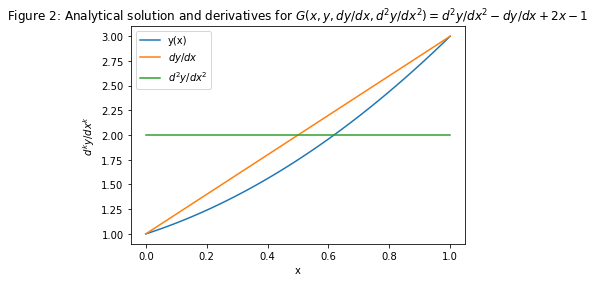

In [42]:
xmin = 0
xmax = 1
n = 100
x = np.linspace(xmin, xmax, n)
y = np.zeros(n)
dy_dx = np.zeros(n)
d2y_dx2 = np.zeros(n)
for i in range(n):
    y[i] = ya(x[i])
    dy_dx[i] = dya_dx(x[i])
    d2y_dx2[i] = d2ya_dx2(x[i])
plt.xlabel('x')
plt.ylabel('$d^ky/dx^k$')
plt.plot(x, y, label = 'y(x)')
plt.plot(x, dy_dx, label = "$dy/dx$")
plt.plot(x, d2y_dx2, label = "$d^2y/dx^2$")
plt.legend()
plt.title("Figure 2: Analytical solution and derivatives for $G(x,y,dy/dx,d^2y/dx^2)=d^2y/dx^2-dy/dx+2x-1$");

Define the differential equation itself, and its derivatives.

In [43]:
# Define the original differential equation:
def G(x, y, dy_dx, d2y_dx2):
    return d2y_dx2 - dy_dx + 2*x - 1

# Define the y-partial derivative of the differential equation.
def dG_dy(x, y, dy_dx, d2y_dx2):
    return 0

# Define the dy/dx-partial derivative of the differential equation.
def dG_dydx(x, y, dy_dx, d2y_dx2):
    return -1

# Define the d2y/dx2-partial derivative of the differential equation.
def dG_d2ydx2(x, y, dy_dx, d2y_dx2):
    return 1

The initial conditions are:

In [44]:
A = 1
Ap = 1

## Create the training data

For the purposes of this example, an evenly-spaced set of training points will be used to train the neural network.

In [45]:
nt = 10
xt = np.linspace(xmin, xmax, num = nt)

Note that repeated runs of the same ODE will usually result in slightly different solutions, due to the random number generator. To ensure repeatable results, seed the random number generator with a fixed value before each run.

## Train the model to solve the ODE

We can now train the network. The call below shows the minimum arguments required to call the `nnode2ivp()` function. All tunable parameters (learning rate `eta`, hidden layer size `H`, number of training epochs `max_epochs`) are given default values (`0.01`, `10`, `1000`, respectively). The training function returns the estimated values of $y$, $\frac {dy}{dx}$, and $\frac {d^2y}{dx^2}$ at the training points. When the `verbose` option is set to `True`, the function prints out the epoch number and current value of the mean-squared error of $G_i$.

In [46]:
from nnode2ivp import nnode2ivp
np.random.seed(0)
(yt, dyt_dx, d2yt_dx2) = nnode2ivp(G, A, Ap, dG_dy, dG_dydx, dG_d2ydx2, xt, verbose = True)

0 9.755207292389036
1 2.883228136957397
2 1.0519024825515224
3 0.773574201945924
4 0.5949479668482202
5 0.45885057158846093
6 0.3497418568147228
7 0.26181790902236746
8 0.19221225088653024
9 0.1384760095801059
10 0.09821334437348855
11 0.06884933172629643
12 0.047990932543861935
13 0.03347106893821171
14 0.023546897885725233
15 0.01684237940760996
16 0.012355248175078042
17 0.009360605106232
18 0.007360568590165239
19 0.0060149507451356995
20 0.005096964706793596
21 0.004458123584880989
22 0.003999972876924757
23 0.0036608307976438454
24 0.0033987560572818036
25 0.0031891931751649384
26 0.003014056649061969
27 0.0028641039123989084
28 0.002731083174738829
29 0.0026119098717372093
30 0.0025023500451281846
31 0.0024017447603359434
32 0.002307517243231574
33 0.0022199427133529643
34 0.002137155714963197
35 0.002059778290489025
36 0.001986279101801113
37 0.0019173981736476018
38 0.0018517867488398142
39 0.001790214204644877
40 0.0017314516310164701
41 0.0016762633811081228
42 0.00162351249

370 0.0005285613935618184
371 0.0005285536675841094
372 0.000528545811524282
373 0.0005285382995585365
374 0.0005285306641029156
375 0.0005285233600244287
376 0.0005285159387496746
377 0.0005285088366236153
378 0.0005285016233088328
379 0.0005284947173832164
380 0.0005284877060024852
381 0.0005284809907016031
382 0.000528474175416928
383 0.0005284676453350591
384 0.000528461020489689
385 0.0005284546703851166
386 0.000528448230497002
387 0.0005284420552863255
388 0.0005284357950419807
389 0.0005284297897945634
390 0.0005284237040431867
391 0.0005284178639759436
392 0.0005284119477237611
393 0.0005284062681960925
394 0.0005284005166009354
395 0.0005283949931099598
396 0.0005283894014760791
397 0.0005283840296520158
398 0.00052837859342519
399 0.0005283733690269041
400 0.0005283680837894866
401 0.0005283630027002988
402 0.0005283578641668364
403 0.0005283529223903867
404 0.0005283479264031436
405 0.0005283431200595332
406 0.0005283382625842902
407 0.0005283335879063105
408 0.000528328865

731 0.0005279987606122434
732 0.0005279987079048304
733 0.0005279986560547175
734 0.0005279986047853399
735 0.0005279985543481141
736 0.0005279985044775263
737 0.0005279984554146432
738 0.0005279984069046963
739 0.0005279983591787532
740 0.0005279983119922823
741 0.0005279982655668807
742 0.0005279982196677405
743 0.0005279981745074187
744 0.00052799812986053
745 0.0005279980859308282
746 0.0005279980425019802
747 0.0005279979997693912
748 0.000527997957525377
749 0.0005279979159572762
750 0.0005279978748657294
751 0.0005279978344303732
752 0.0005279977944599027
753 0.0005279977551264351
754 0.0005279977162463638
755 0.0005279976779848057
756 0.0005279976401654206
757 0.0005279976029465405
758 0.0005279975661588988
759 0.0005279975299542715
760 0.0005279974941702383
761 0.0005279974589522528
762 0.0005279974241443929
763 0.0005279973898861892
764 0.0005279973560278883
765 0.0005279973227032775
766 0.0005279972897686375
767 0.0005279972573521977
768 0.000527997225316019
769 0.0005279971

Plot the results of this training run.

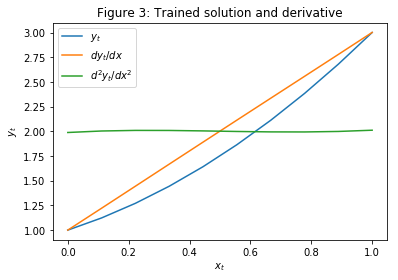

In [47]:
plt.plot(xt, yt, label = '$y_t$')
plt.plot(xt, dyt_dx, label = '$dy_t/dx$')
plt.plot(xt, d2yt_dx2, label = '$d^2y_t/dx^2$')
plt.xlabel('$x_t$')
plt.ylabel('$y_t$')
plt.legend()
plt.title("Figure 3: Trained solution and derivative");

Plot the error in the estimated solution and derivatives.

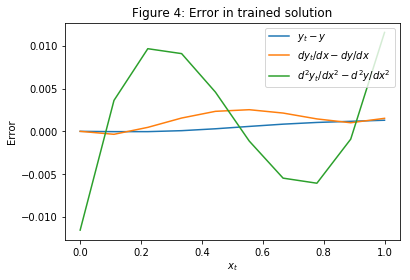

In [48]:
y = np.zeros(nt)
dy_dx = np.zeros(nt)
d2y_dx2 = np.zeros(nt)
for i in range(nt):
    y[i] = ya(xt[i])
    dy_dx[i] = dya_dx(xt[i])
    d2y_dx2[i] = d2ya_dx2(xt[i])
plt.plot(xt, yt - y, label = '$y_t-y$')
plt.plot(xt, dyt_dx - dy_dx, label = '$dy_t/dx-dy/dx$')
plt.plot(xt, d2yt_dx2 - d2y_dx2, label = '$d^2y_t/dx^2-d^2y/dx^2$')
plt.xlabel('$x_t$')
plt.ylabel('Error')
plt.legend()
plt.title("Figure 4: Error in trained solution");